# Self study for Difusion models

This notebook was done in a selfstudy to check my own understanding of diffusion models. Specifically I tried to replicate the results in the paper [**Generative Modeling by Estimating Gradients of the Data Distribution** by Song et al. (2019)](https://proceedings.neurips.cc/paper/2019/hash/3001ef257407d5a371a96dcd947c7d93-Abstract.html?ref=https://githubhelp.com)

### Importing Libraries

In [1]:
#imports
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import numpy as np
import random
import matplotlib.image as mpimg

### Generation of noise sequence

We need a sequence of noise to add to the images 

This sequence satisifies the following conditions:
* $\sigma_1=1$
* $\sigma_{10}=0.01$
* $\exists c \in \mathbb{R}, \forall i \in [0, 9] : \frac{\sigma_i}{\sigma_{i+1}} = c$

In [2]:
#generate sequence of noices
L = 10  # Number of noise levels
sigma_max = 1  # Initial term
sigma_min = 0.01 # Last term

# Calculate the ratio r
r = (sigma_max / sigma_min) ** (1 / (L - 1))

# Generate the series of standard deviations
sigma_sequence = [x for x in reversed([sigma_min * r**i for i in range(L)])]

print("Sequence:", sigma_sequence)

Sequence: [1.0000000000000002, 0.5994842503189411, 0.3593813663804628, 0.2154434690031884, 0.12915496650148842, 0.07742636826811271, 0.046415888336127795, 0.02782559402207125, 0.01668100537200059, 0.01]


### Load the dataset

In [3]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 494kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.98MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
#set up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Specify Unet Architecture

Use an encoder with 3 layers and ReLU as an activation function. After the encoding normalize according to the Paper (Appendix A1). Note that I used the basic instance normalization, as I do not care about shifted colors in a black and white image. Before decoding take the noise initally added to the image into account i.e. give it to the network as a feature vector. In accordance to the paper (Appendix A2) I used dilations in each layer except the first.

In [5]:
#define Unet architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, dilation=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, dilation=2),
            nn.ReLU(),
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, padding=1, dilation=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, dilation=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, padding=1, dilation=1)
        )
        # Add a fully connected layer to incorporate the noise given as a scalar input
        self.fc = nn.Linear(1, 256)  # transform to feature vector

        # CIN parameters: one set of gamma/beta per sigma (L,C) with L=10 (number of noise levels) and C=256 (since we do normalization after the thrird convolution)
        self.gamma = nn.Parameter(torch.randn(L, 256))
        self.beta = nn.Parameter(torch.randn(L, 256))

    def forward(self, x, noise):
        # Process the scalar input through a fully connected layer
        scalar_features = self.fc(torch.tensor([noise], device=device).unsqueeze(1))  # Add batch dimension
        scalar_features = scalar_features.view(scalar_features.size(0), 256, 1, 1)  # Reshape to match feature map dimensions

        # Encoder and decoder processing
        enc = self.encoder(x)

        #apply normalization
        sigma_index = sigma_sequence.index(noise)
        enc = self.conditional_instance_norm(enc, sigma_index)

        #add the scalar features to the result of the encoding
        enc = enc + scalar_features

        #decode results again
        dec = self.decoder(enc)

        return dec

    #helper function to perform conditional instance normalization (CIN)
    def conditional_instance_norm(self, x, sigma_idx):

        # Calculate mean and std per feature map
        mu = x.mean(dim=(2, 3), keepdim=True)  # Mean along spatial dimensions
        sigma = x.std(dim=(2, 3), keepdim=True) + 1e-5  # Std with stability term

        # Select gamma and beta for the given sigma
        gamma = self.gamma[sigma_idx].view(1, -1, 1, 1)
        beta = self.beta[sigma_idx].view(1, -1, 1, 1)

        # Actually apply conditional instance normalization
        z = gamma * (x - mu) / sigma + beta
        return z


### Defining the loss

This is the denoising loss used to train the Unet. This is equivalent to the function in the paper.

In [6]:
#define the custom loss function
def denoising_loss(y_pred,x_tilde,x_inputs,sigma):
    loss = 0
    for x in x_inputs:
        # Compute the squared norm
        loss = torch.norm((y_pred+(x_tilde-x)/sigma**2), 'fro')**2
    loss *= 0.5
    loss *= sigma**2
    return loss

Helper function to add gaussian noise to an image

In [7]:
#function to add gausian noise to an image
def add_gaussian_noise(image, sigma):

    # Generate Gaussian noise with mean 0 and standard deviation sigma
    noise = torch.randn_like(image) * sigma
    noisy_image = image + noise

    # Clip the values to ensure they are in the valid range [0, 1]
    noisy_image = torch.clamp(noisy_image, 0., 1.)

    return noisy_image

### Training the model

I trained the model using an Adam Optimizer with a learning reate of 0.001. However, due to runtime reasons and because I couldn't use the GPU in google colab for long eneugh I decided to opt for 30 epochs (roughly 14100 iterations which took 30 minutes). After each epoch I plotted the loss.

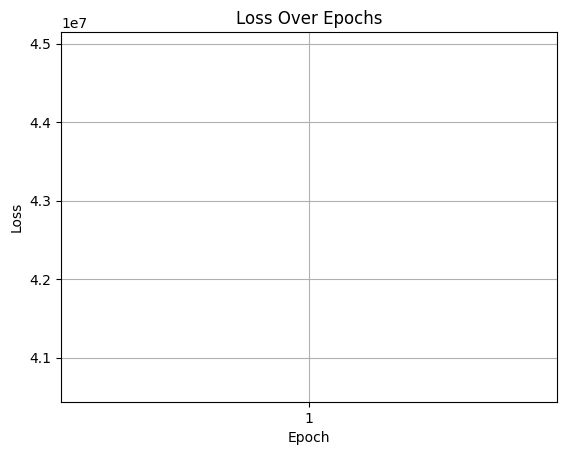

Epoch 1, Loss: 42794051.2847


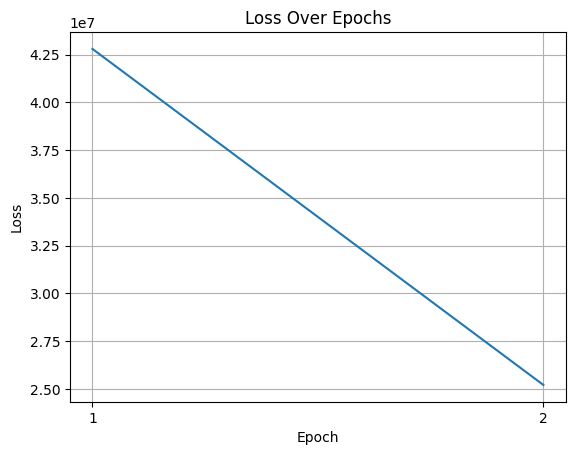

Epoch 2, Loss: 25217347.8653


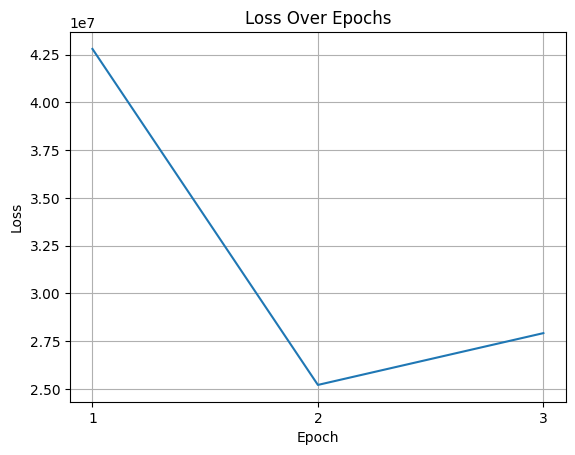

Epoch 3, Loss: 27926230.9442


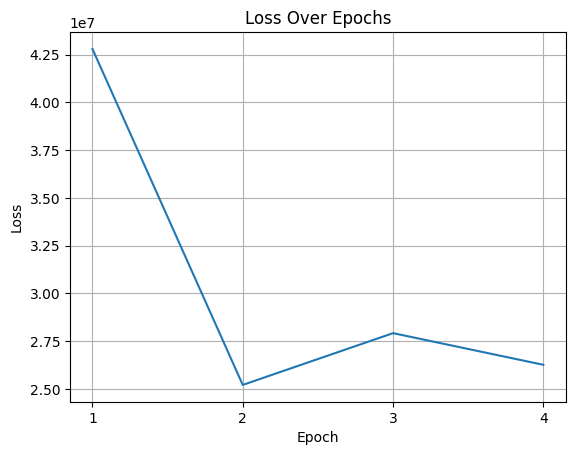

Epoch 4, Loss: 26269442.7524


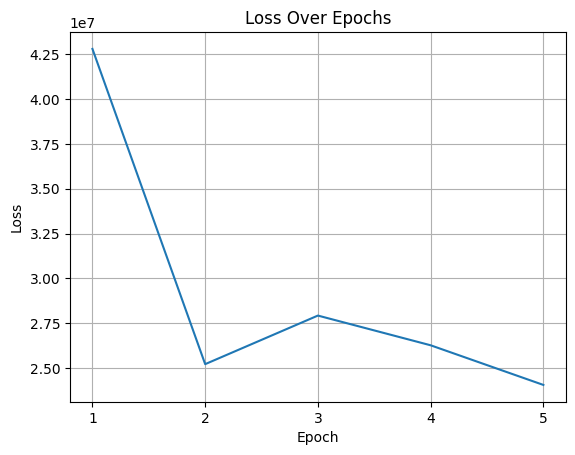

Epoch 5, Loss: 24059391.5892


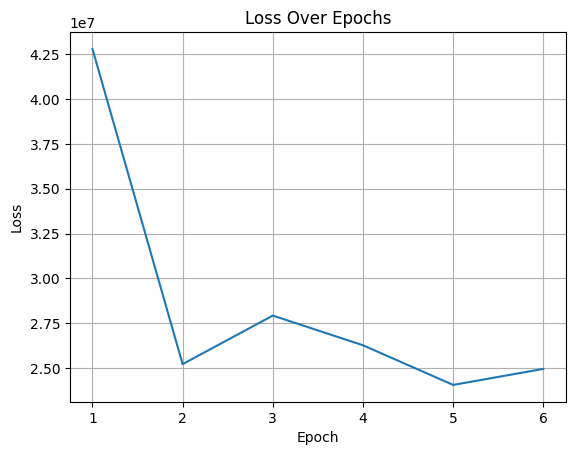

Epoch 6, Loss: 24953518.9275


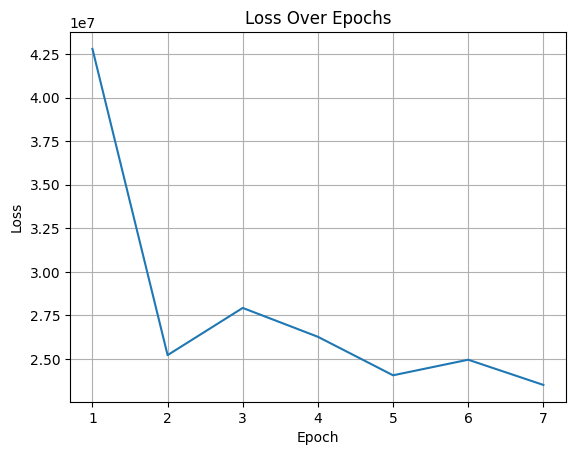

Epoch 7, Loss: 23506905.3446


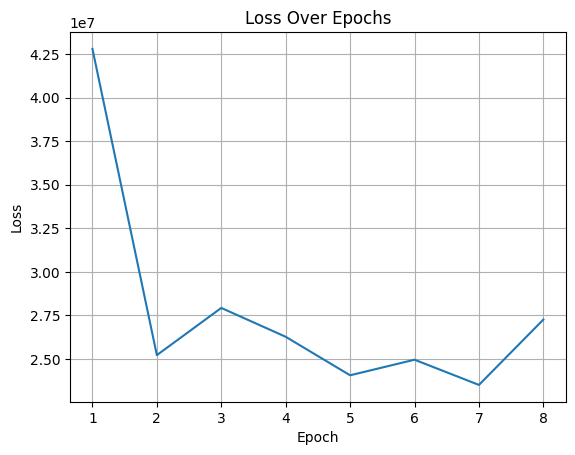

Epoch 8, Loss: 27257333.2553


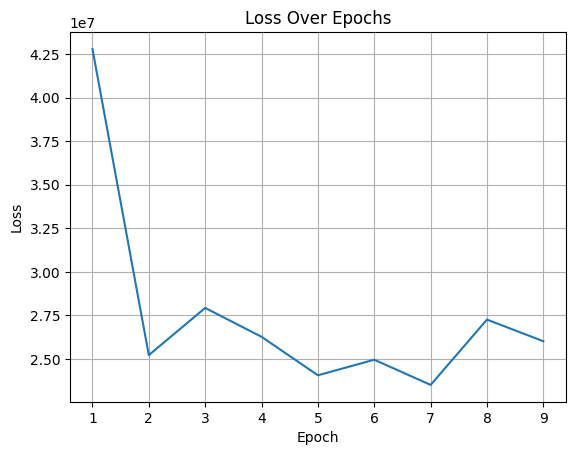

Epoch 9, Loss: 26014273.8164


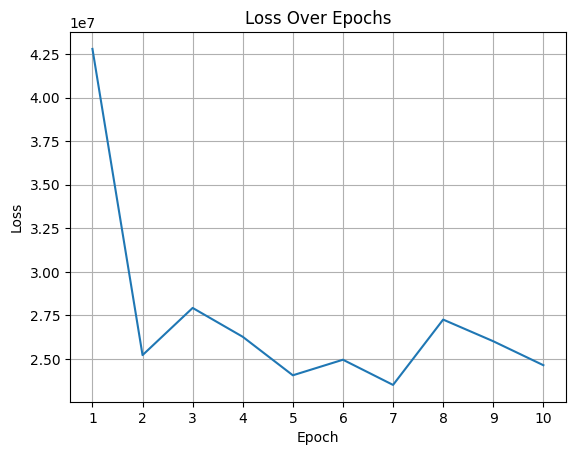

Epoch 10, Loss: 24638716.6448


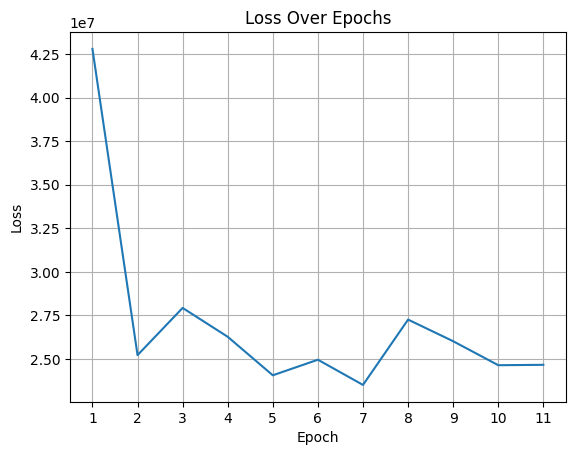

Epoch 11, Loss: 24660759.7373


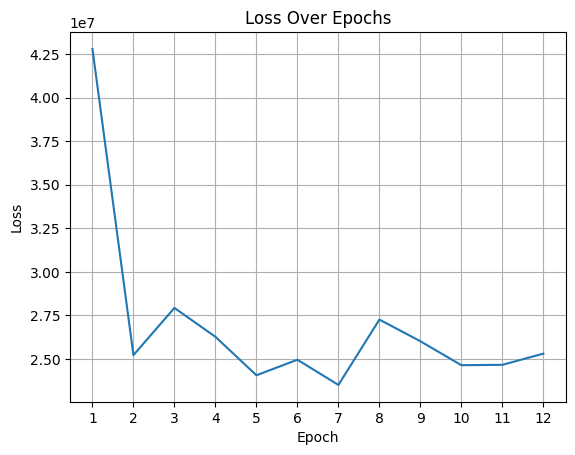

Epoch 12, Loss: 25302422.6219


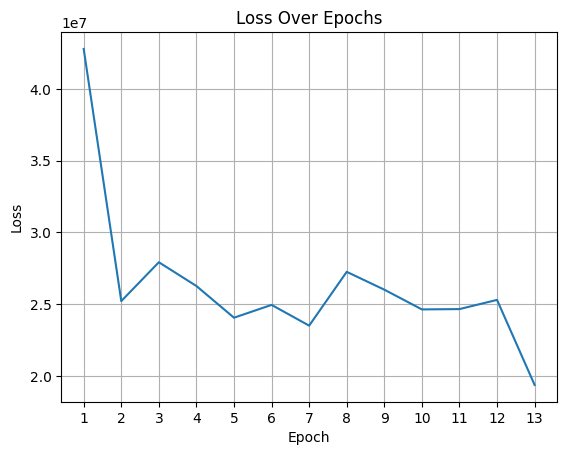

Epoch 13, Loss: 19375325.3782


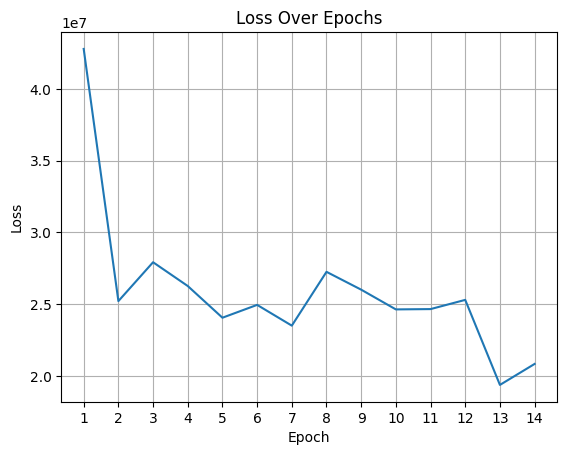

Epoch 14, Loss: 20838244.1388


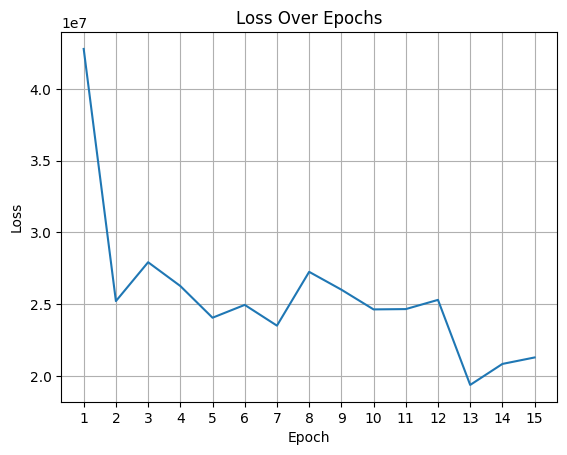

Epoch 15, Loss: 21289381.4135


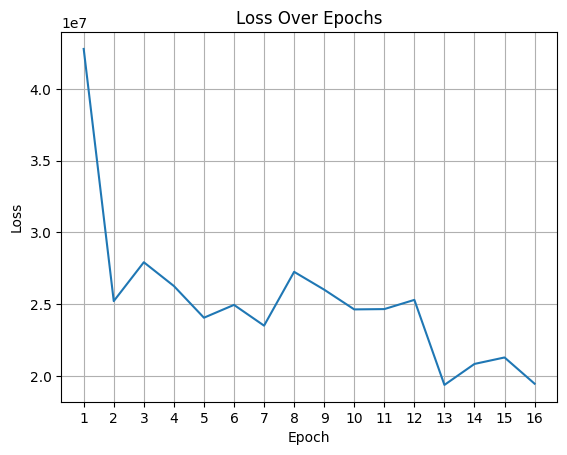

Epoch 16, Loss: 19459549.4652


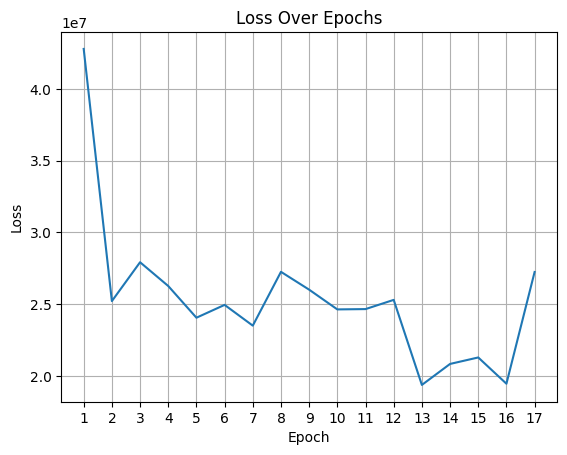

Epoch 17, Loss: 27246438.8163


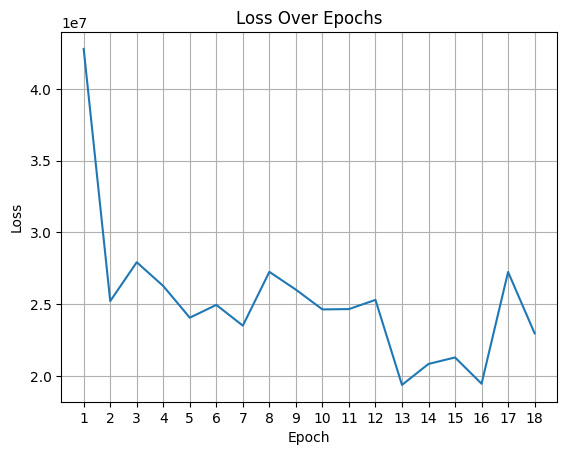

Epoch 18, Loss: 22973693.6968


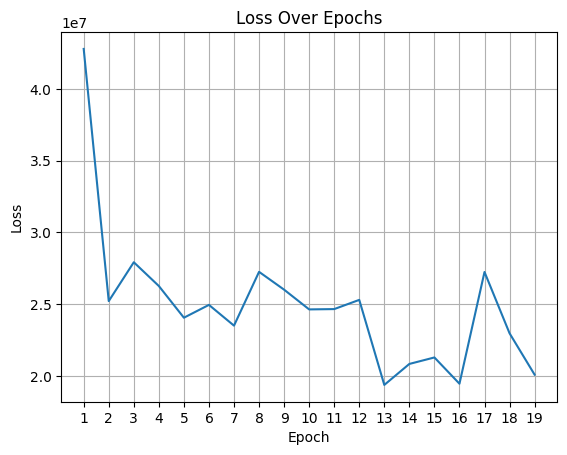

Epoch 19, Loss: 20090225.2448


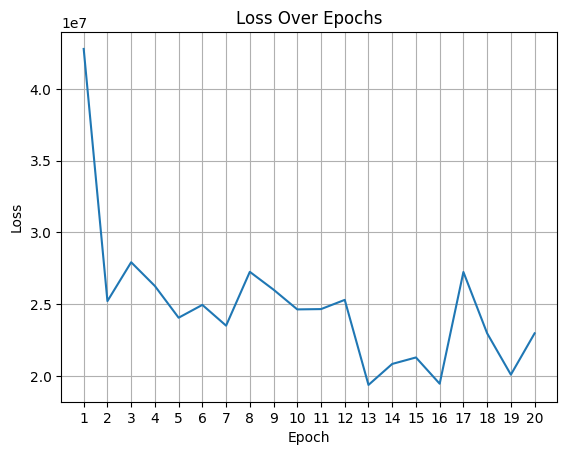

Epoch 20, Loss: 22971954.3532


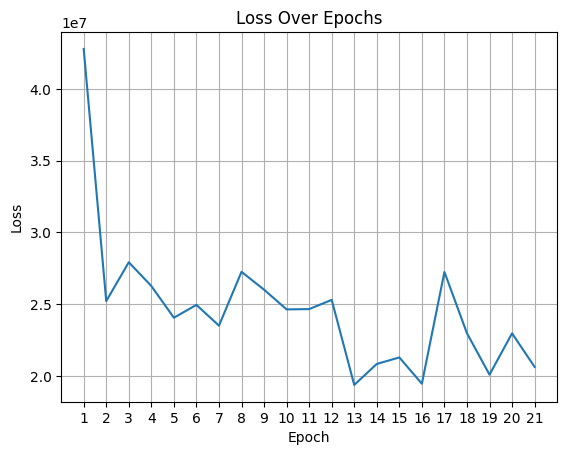

Epoch 21, Loss: 20629240.2612


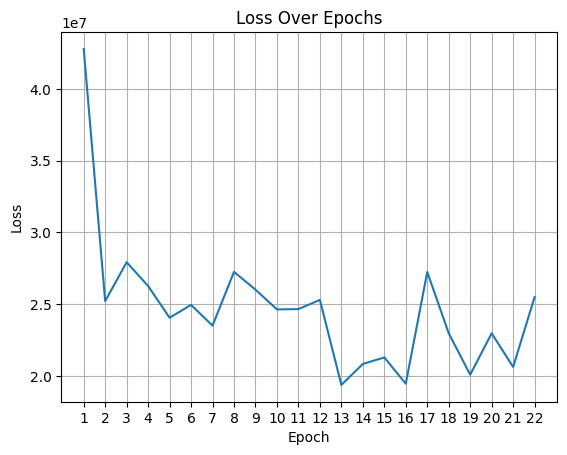

Epoch 22, Loss: 25501263.3743


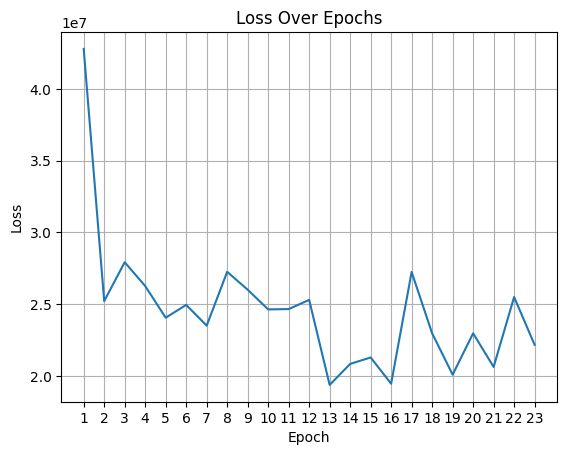

Epoch 23, Loss: 22172874.6125


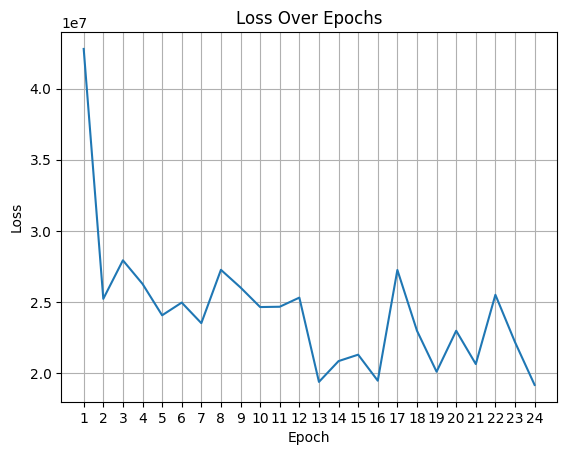

Epoch 24, Loss: 19161972.0313


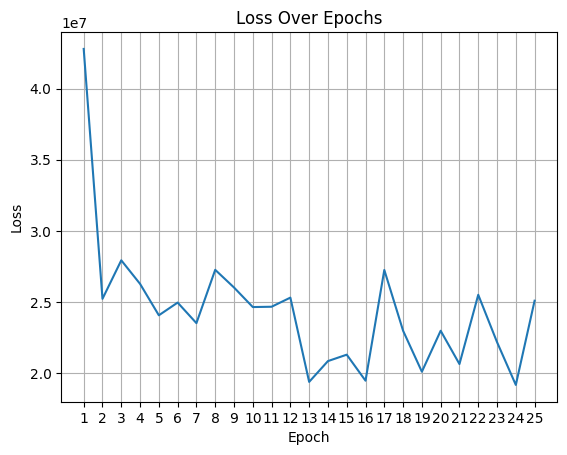

Epoch 25, Loss: 25085721.8663


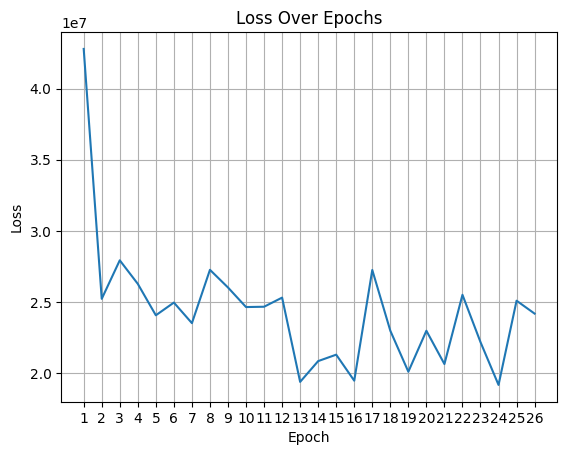

Epoch 26, Loss: 24177160.3471


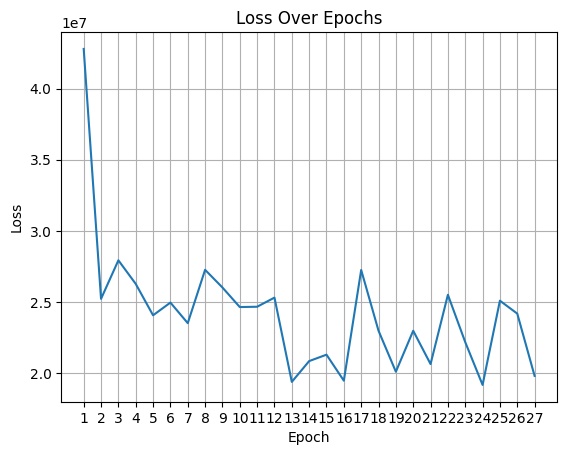

Epoch 27, Loss: 19794607.7480


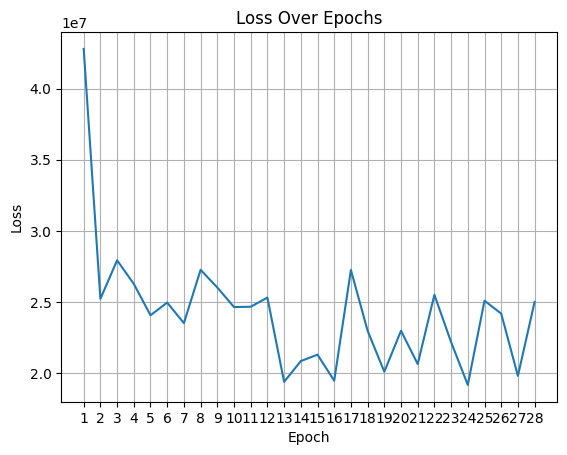

Epoch 28, Loss: 25002709.6814


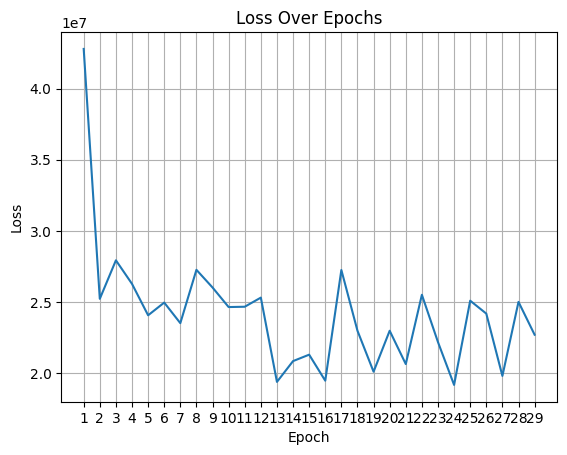

Epoch 29, Loss: 22692903.0688


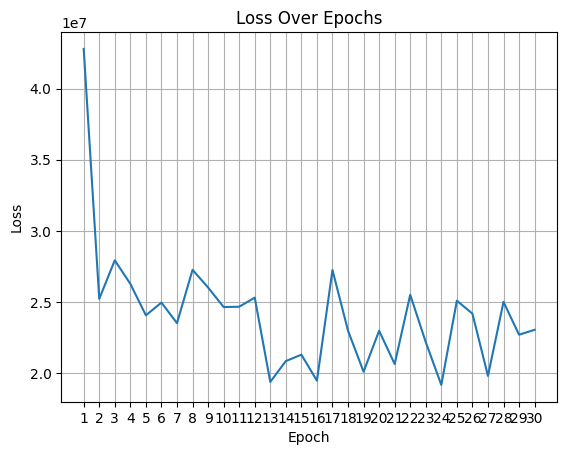

Epoch 30, Loss: 23038802.3623


In [8]:
#train the model
model = UNet().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

epoch_loss_list = []

for epoch in range(30):

    # Ensure the model is in training mode
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:

        # Move data to the appropriate device
        x_inputs = inputs.to(device)

        #add noise to images
        sigma = random.choice(sigma_sequence) #choose a sigma from the sequence of sigmas randomly
        x_tilde = add_gaussian_noise(x_inputs,sigma)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(x_tilde,sigma)

        # Compute the loss
        loss = denoising_loss(outputs, x_tilde,x_inputs,sigma)

        # Backpropagation
        loss.backward()

        # Optimizer step
        optimizer.step()

        running_loss += loss.item()

    # Compute the average loss for the current epoch
    epoch_loss = running_loss / len(train_loader)

    epoch_loss_list.append(epoch_loss)

    # Plot the loss after each epoch
    plt.plot([i+1 for i in range(epoch + 1)], epoch_loss_list, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.xticks([i+1 for i in range(epoch + 1)])
    plt.title('Loss Over Epochs')

    plt.pause(0.1)

    # Print loss for the current epoch
    print(f'Epoch {epoch + 1}, Loss: {epoch_loss:.4f}')


### Implementation of Lagravian dynamics (denoising)

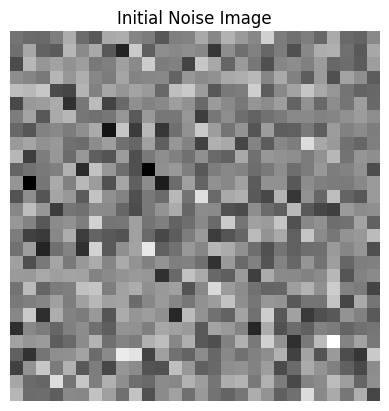

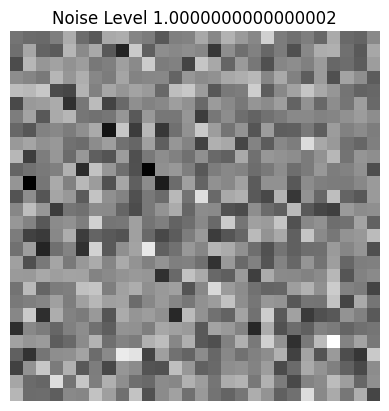

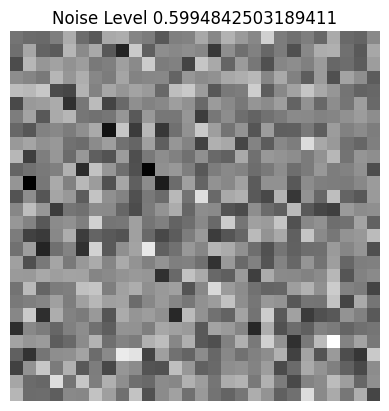

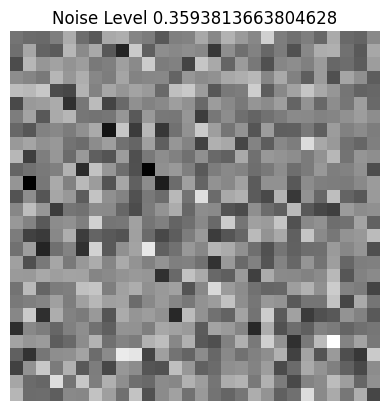

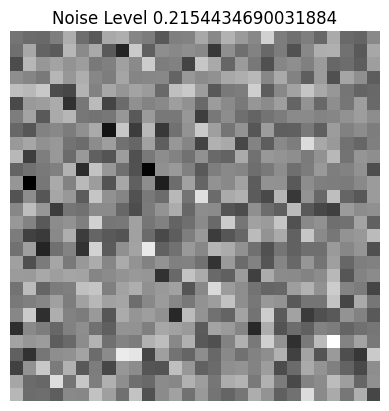

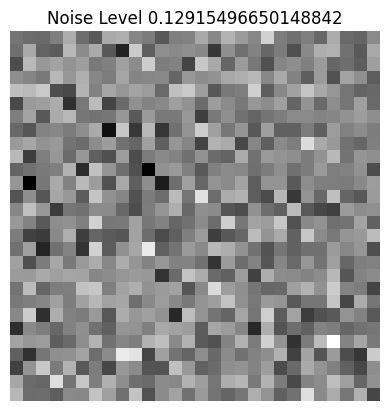

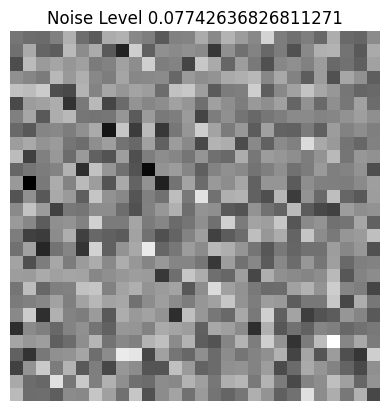

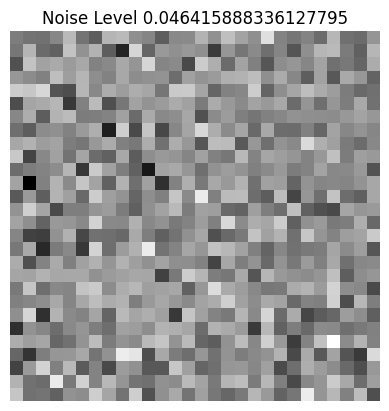

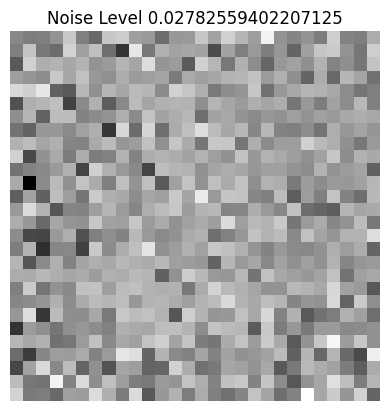

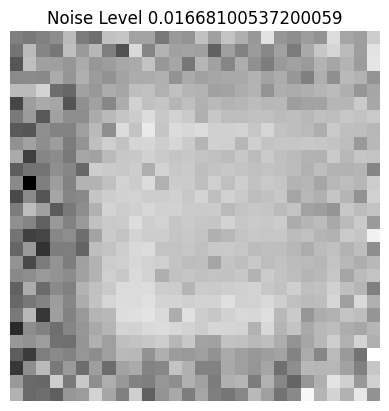

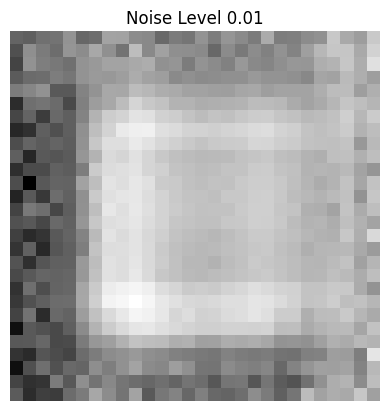

In [10]:
#lagravian dynamics

#set hyperparameters
T = 100
epsilon = 2*1e-5

# Sample a noise image with dimensions 28x28
x_t = np.random.normal(0, sigma_sequence[0], (28, 28))

# Convert the NumPy array to a PyTorch tensor
x_t = torch.tensor(x_t, dtype=torch.float32).to(device)

# Reshape x_t to have the correct dimensions for the UNet model
# Add channel and batch dimensions: (1, 1, 28, 28)
x_t = x_t.unsqueeze(0).unsqueeze(0)
visualize_x_t = x_t.clone().squeeze(0).squeeze(0).to('cpu')

# Print initial image
plt.imshow(visualize_x_t, cmap='gray')
plt.title("Initial Noise Image")
plt.axis('off')
plt.show()

#iterate over all noise levels
for l in range(L):
  #get sigma
  sigma = sigma_sequence[l]

  #iterate over T
  for _ in range(T):
    #perform update for x_t+1
    s = model.forward(x_t,sigma) #device is cuda
    x_t_1 = x_t+(epsilon/2)*s+math.sqrt(epsilon)*torch.randn(1).to(device)
    #do so again for new x_t
    x_t = x_t_1.clone()

  #get np represantation for visualization
  visualize = x_t.clone().squeeze(0).squeeze(0).to('cpu').detach().numpy()

  #visualize_x_t changes in between different sigma values --> why is it still the same?????

  plt.imshow(visualize, cmap='gray')
  plt.title(f"Noise Level {sigma}")
  plt.axis('off')
  plt.show()

### Additional Note

On a previous rerun we achieved even better results (at least using visual confirmation). However using the specified hyperparamters the results shown above were best. The previous result looked as follows:

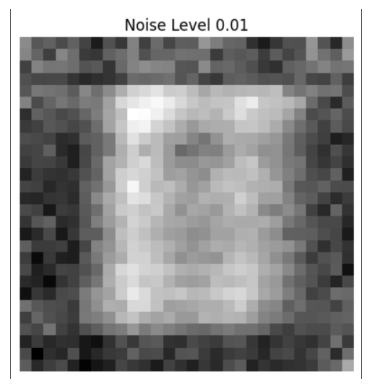

In [2]:
# Load and display the image
image = mpimg.imread('Screenshot 2024-12-07 054445.png')
plt.imshow(image)
plt.axis('off')  # Remove axes for better visualization
plt.show()

### Concluding remarks

Given more suffiencient training ressources I am confident that we could have produced something better than the given image that only slightly resembles an eight. However, the results still seem to show that the approach (even given my limited ressources) works sufficiently well. 